Основная цель проекта: исследовать информацию о расходах клиента банка и выяснить, по какой информации из транзакций - сумма транзакции, дата транзакции, категория трат транзакиции или что-то еще - можно отличить клиентов банка разных возрастных категорий. 

1. Для начала подготовим данные к работе. Для загрузки данных подключим папку на Google диске.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


2. Импортируем необходимые для работы с данными и построения графиков библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

3. Загрузим данные с помощью библиотеки Pandas

In [ ]:
group_descr = pd.read_csv('/content/drive/MyDrive/final_project_data/small_group_description.csv')
transactions = pd.read_csv('/content/drive/MyDrive/final_project_data/transactions_train.csv')
target = pd.read_csv('/content/drive/MyDrive/final_project_data/train_target.csv')

2. Рассмотрим, как представлены данные. Информация хранится в 3х файлах - small_group_description.csv, transactions_train.csv, train_target.csv.

Файл **small_group_description.csv** содержит сопоставление номера группы её содержанию. Он содержит следующие столбцы:

*   *small_group* - содержит описание типа транзакции
*   *small_group_code* - содержит соответствующий описанию код типа транзакции.

Фвйл **transactions_train.csv** содержит данные о проведенных транзакциях за определенный период. Он содержит следующие столбцы:
*   *сlient_id* – уникальный номер клиента;

*   *trans_date* – дата транзакции (представляет из себя просто номер дня в хронологическом порядке, начиная от заданной даты);

*   *small_group* – группа транзакций, характеризующих тип транзакции (например, продуктовые магазины, одежда, заправки, детские товары и т.п.);

*   *amount_rur* – сумма транзакции (для анонимизации данные суммы были трансформированы без потери структуры).

Файл **train_target.csv** содержит информацию о Клиенте и метку возрастной группы, к которой он относится. Он содержит следующие столбцы:

*   *client_id* – уникальный номер Клиента (соответствует client_id из файла transactions_train.csv);

*   *bins* – метка возраста. 



3. Проведем первичный анализ полученных данных. Посмотрем количественные характеристики датасета.

In [ ]:
print(f"Количество существующих типов транзакций: {len(group_descr)}")
print(f"Количество уникальных клиентов в выборке: {len(target)}")
print(f"Количество транзакций в выборке: {len(transactions)}")
print(f"Количество присутствующих  в выборке типов транзакций: {len(transactions.small_group.unique())}")
print(f"Количество присутствующих  в выборке клиентов: {len(transactions.client_id.unique())}")
print(f"Временной промежуток в выборке составляет: {transactions.trans_date.max()-transactions.trans_date.min()+1} дней - с {transactions.trans_date.min()} по {transactions.trans_date.max()}")
print(f"Минимальная сумма транзакции в выборке: {transactions.amount_rur.min()}")
print(f"Максимальная сумма транзакции в выборке: {transactions.amount_rur.max()}")
print(f"Средняя сумма транзакции в выборке: {round(transactions.amount_rur.mean(),2)}")
print(f"Стандартное отклонение суммы транзакции в выборке: {round(transactions.amount_rur.std(),2)}")
print(f"Количество отсутствующих данных (NA, None): {transactions.isna().sum().sum()}")

Количество существующих типов транзакций: 204
Количество уникальных клиентов в выборке: 30000
Количество транзакций в выборке: 26450577
Количество присутствующих  в выборке типов транзакций: 202
Количество присутствующих  в выборке клиентов: 30000
Временной промежуток в выборке составляет: 730 дней - с 0 по 729
Минимальная сумма транзакции в выборке: 0.001
Максимальная сумма транзакции в выборке: 400086.79
Средняя сумма транзакции в выборке: 55.86
Стандартное отклонение суммы транзакции в выборке: 369.49
Количество отсутствующих данных (NA, None): 0


По полученным значениям можно сделать следующие выводы:

1. В выборке присутсвуют не все возможные типы транзакций.
2. В выборке рассматривается промежуток длиной в 2 года (невисокосный и високосный).
3. В выборке присутствует большой разброс в значениях сумм транзакций. Из этого следует, что возможно некоторые транзакции с большой суммой являются единичными. Это необходимо учитывать при дальнейшем анализе.
4. В данных нет пропусков, что позволяет избежать этой части обработки данных.




4. Объединим данные файлов в один датафрейм для удобства анализа. Для этого предварительно приведем в соответствие название столбцов файлов.

In [ ]:
transactions.rename(columns={'small_group':'small_group_code'},inplace= True)
data = pd.merge(transactions, target, on="client_id")
data = data.merge(group_descr, on = 'small_group_code')
data = data.drop('small_group_code', axis=1)

Полученный датафрейм имеет следующую структуру:

In [ ]:
data.head()

,client_id,trans_date,amount_rur,bins,small_group
0,33172,6,71.463,0,Аптеки
1,33172,34,26.332,0,Аптеки
2,33172,37,8.569,0,Аптеки
3,33172,63,4.045,0,Аптеки
4,33172,76,19.692,0,Аптеки


5. Посмотрим на основные распределения данных с помощью графиков

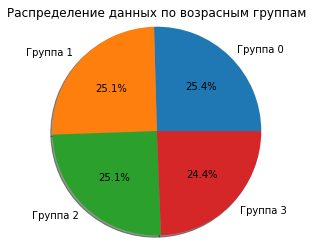

In [ ]:
fig,ax = plt.subplots()
ax.pie(data.bins.value_counts(),labels=['Группа 0','Группа 1','Группа 2','Группа 3'], autopct='%1.1f%%',shadow=True, radius=1.2)
ax.set_title('Распределение данных по возрасным группам')
plt.show()

По полученной диаграмме видно, что данные распределены по возрастным группам равномерно.

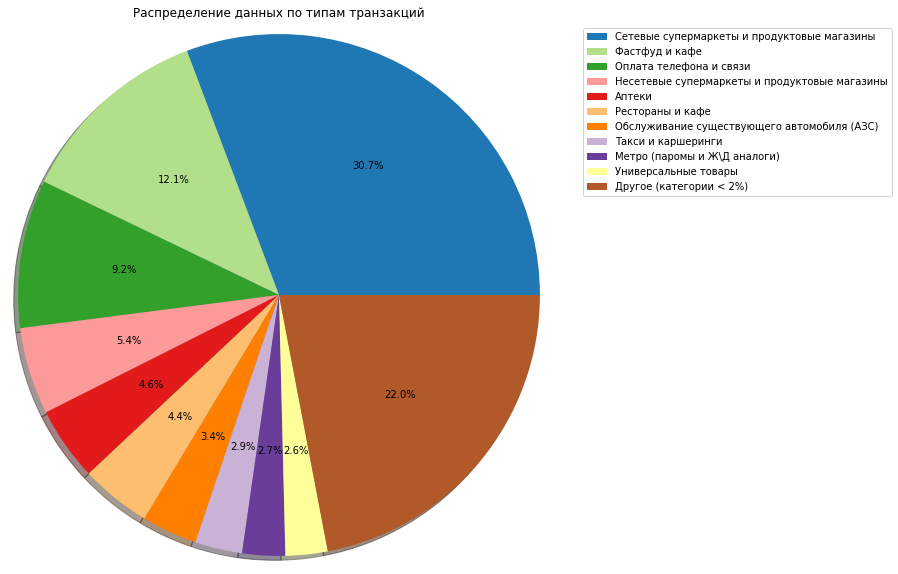

In [ ]:
fig,ax = plt.subplots()
categories = data['small_group'].value_counts()
categories_proc = categories.div(data['small_group'].value_counts().sum())*100
categories_proc_other = categories_proc[categories_proc<=2].sum()
categories_proc = categories_proc[categories_proc>2]
categories_proc['Другое (категории < 2%)'] = categories_proc_other
cmap = plt.cm.get_cmap('Paired')
pie_colors = cmap(np.arange(1,len(categories_proc)*100))
ax.pie(categories_proc, autopct='%1.1f%%',shadow=True, radius=1.2, colors= pie_colors)
ax.set_title('Распределение данных по типам транзакций')
ax.legend(labels = categories_proc.index,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.set_size_inches(10,10)
plt.show()

По полученной диаграмме видно, что в выборке присутсвуют как наиболее популярные типы транзакций (более 30 %), так и довольно редкие (менее 2%). Построим гистограммы количества операций наиболее популярных и наименее популярных категорий расходов.

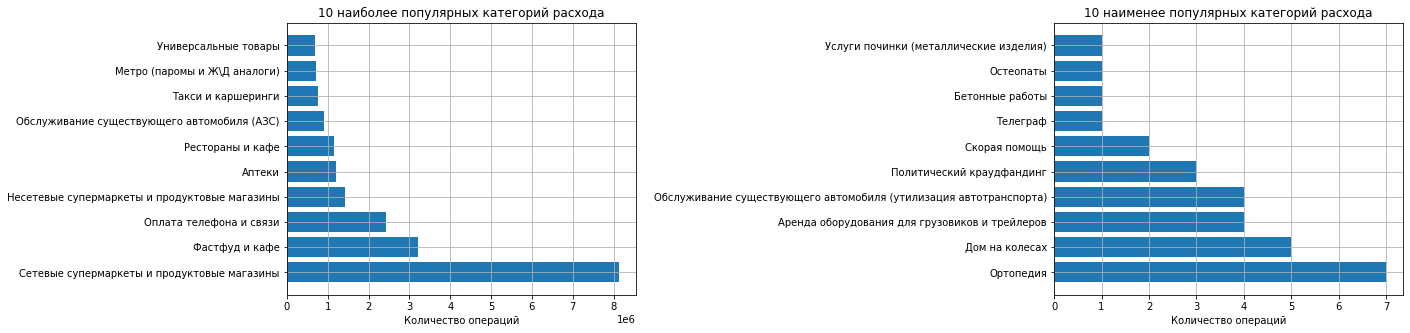

In [ ]:
categories = data['small_group'].value_counts()
fig,ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 1.2)
ax[0].barh(categories.index[:10], categories[:10])
ax[1].barh(categories.index[-10:], categories[-10:],)
ax[0].set_xlabel('Количество операций')
ax[1].set_xlabel('Количество операций')
ax[0].set_title('10 наиболее популярных категорий расхода')
ax[1].set_title('10 наименее популярных категорий расхода')
ax[0].grid()
ax[1].grid()
fig.set_size_inches(20,5)
plt.show()

По полученным диаграммам видим, что в выборке присутствуют настолько редкие категории, что к ним относится менее 10 транзакций. Выводы по таким категориям могут иметь большую статистическую погрешность (не достаточно информации для обобщения). Исключим такие категории из рассмотрения.

In [ ]:
rare_categories = categories[categories<=10]
data = data.drop(data[data.small_group.isin(rare_categories.index.to_list())].index)
print(f"Количество редких категорий: {len(rare_categories)}")

Количество редких категорий: 13


С учетом удаленных категорий, посмотрим на наиболее и наименее популярные категории по возрастным группам.

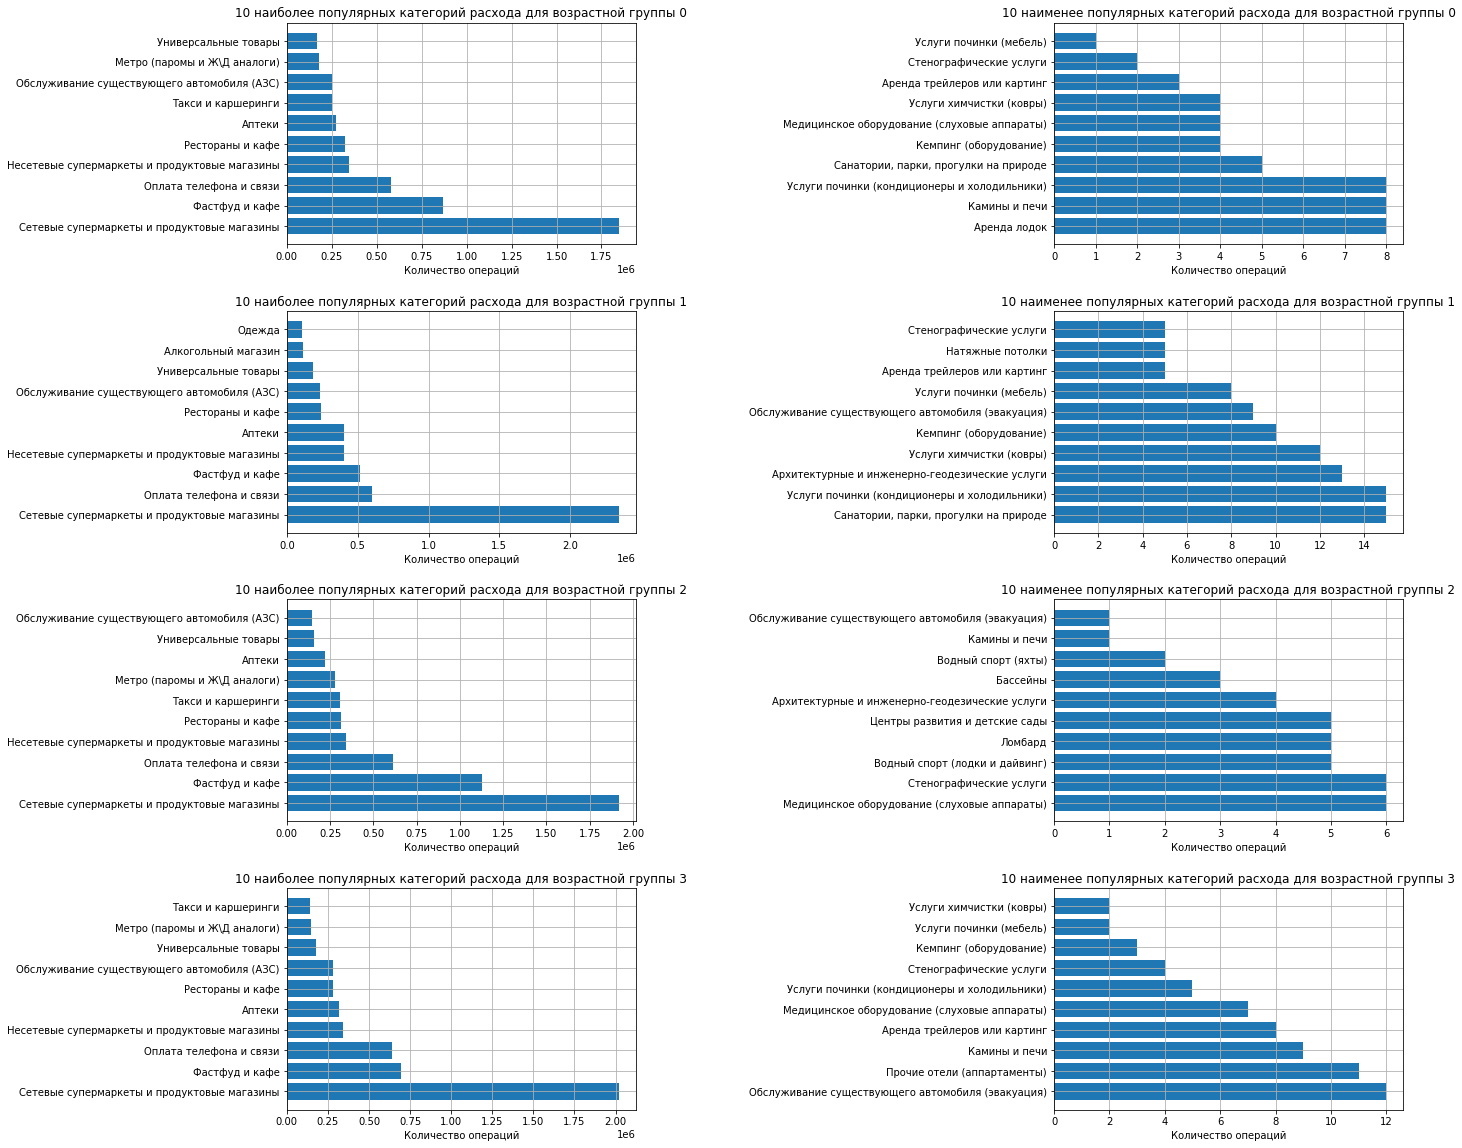

In [ ]:
categories_by_age = data.groupby('bins')['small_group'].value_counts()
fig,ax = plt.subplots(4,2)
plt.subplots_adjust(wspace = 1.2,hspace = 0.3)
for i in range(4):
  ax[i,0].barh(categories_by_age[i].index[:10], categories_by_age[i][:10])
  ax[i,1].barh(categories_by_age[i].index[-10:], categories_by_age[i][-10:])
  ax[i,0].set_xlabel('Количество операций')
  ax[i,1].set_xlabel('Количество операций')
  ax[i,0].set_title(f'10 наиболее популярных категорий расхода для возрастной группы {i}')
  ax[i,1].set_title(f'10 наименее популярных категорий расхода для возрастной группы {i}')
  ax[i,0].grid()
  ax[i,1].grid()
fig.set_size_inches(20,20)
plt.show()

По полученным данным видно, что наименее популярные категории разнятся в зависимости от возрастной группы, но из-за малого количества операций обобщения по этим категориям будут некорректными. А вот анализ популярных категорий позволяет сделать следующие наблюдения:

1. Есть категории, наиболее характерные для определенной группы (например, одежда и алкогольные магазины для группы 1), но в основном состав наиболее популярных категорий постоянен вне зависимости от группы.
2. Есть категории (например, фастфуд и кафе) по количеству транзакций которых можно попытаться различить группы.

Руководствуясь последним выводом, построим гистограмму количества транзакций по общим категориям для каждой группы.

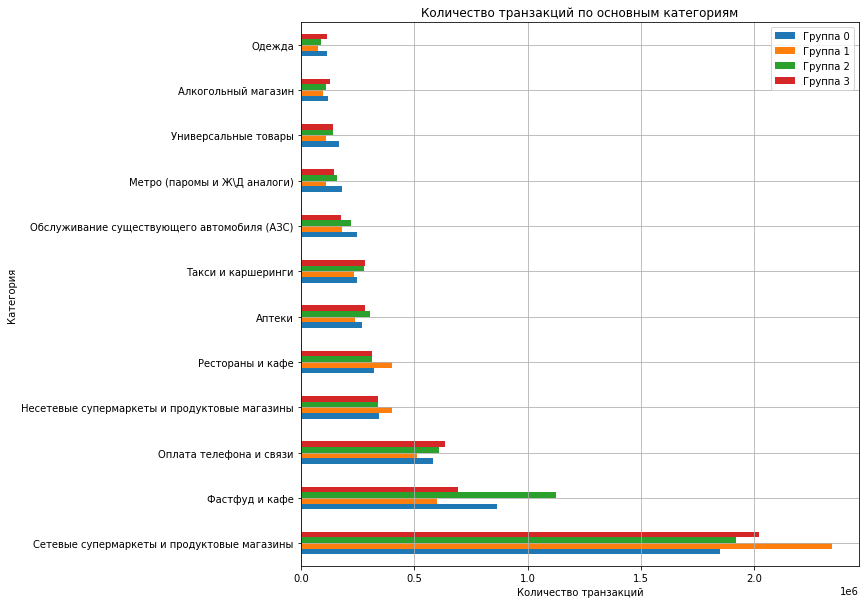

In [ ]:
common_popular_cat = set(categories_by_age[0].index[:10])
for i in range(1,4):
  common_popular_cat.update(categories_by_age[i].index[:10])
data_popular_cat = data.drop(data[~data.small_group.isin(common_popular_cat)].index)
data_popular_cat = data_popular_cat[['small_group','bins']].groupby('bins')['small_group'].value_counts()
data_popular_cat_0 = data_popular_cat[0]
data_popular_cat_1 = data_popular_cat[1]
data_popular_cat_2 = data_popular_cat[2]
data_popular_cat_3 = data_popular_cat[3]
data_popular_cat_group = pd.DataFrame({'group': data_popular_cat_0.index,
                          'value_0': data_popular_cat_0.values,
                          'value_1': data_popular_cat_1.values,
                          'value_2': data_popular_cat_2.values,
                          'value_3': data_popular_cat_3.values,
                          })
data_popular_cat_group.set_index('group', inplace=True)
ax = data_popular_cat_group.plot.barh(figsize = (10,10))
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('Количество транзакций')
ax.set_ylabel('Категория')
ax.set_title(f'Количество транзакций по основным категориям')
ax.grid()

По полученной диаграмме видим, что по почти по всем основным категориям можно достаточно уверенно выделить группу 1, достаточно существенно разделение между группами по категориям "Фастфуд и кафе","Сетевые супермаркеты", "Аптеки", "Оплата телефона и связи". 

Теперь рассмотрим распределение суммы чека. Построим гистограмму распределения. Т.к. согласно первоначальному анализу разброс значений суммы чека достаточно велик, то будем строить гистограмму в логарифмическом масштабе.

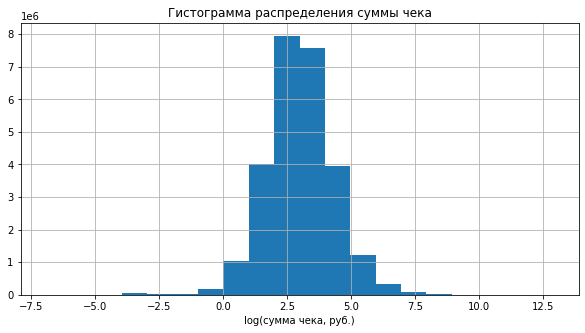

In [ ]:
fig,ax = plt.subplots()
ax.hist(np.log(data['amount_rur']),bins=20)
ax.set_xlabel('log(сумма чека, руб.)')
ax.set_title('Гистограмма распределения суммы чека')
ax.grid()
fig.set_size_inches(10,5)
plt.show()

По гистограмме видно, что наиболее часто встречаются чеки на суммы от 7 (e^2) до 55 (е^4). Обратим внимание, что среднее значение чека входит в этот промежуток.

Теперь рассмотрим величину среднего чека по возрастным группам.

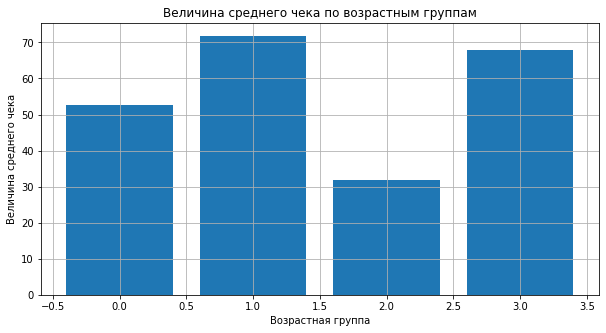

In [ ]:
data_mean_amount = data[['amount_rur','bins']].groupby('bins').mean()
fig,ax = plt.subplots()
ax.bar(data_mean_amount.index, data_mean_amount.values.transpose()[0])
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Величина среднего чека')
ax.set_title(f'Величина среднего чека по возрастным группам')
ax.grid()
fig.set_size_inches(10,5)
plt.show()

Можно заметить, что по величине среднего чека различимы группы 0 и 2. Средний чек для групп 1 и 3 принимает близкие значения. Также обратим внимание, что средний чек 2й группы имеет значение ниже среднего по выборке, средний чек 0й группы приближен к среднему по выборке, а значения для групп 1 и 3 заметно превышают среднее по выборке. 

Рассмотрим зависимость среднего чека в зависимости не только от возрасной группы, но и от категории. Для этого построим гистограмму.

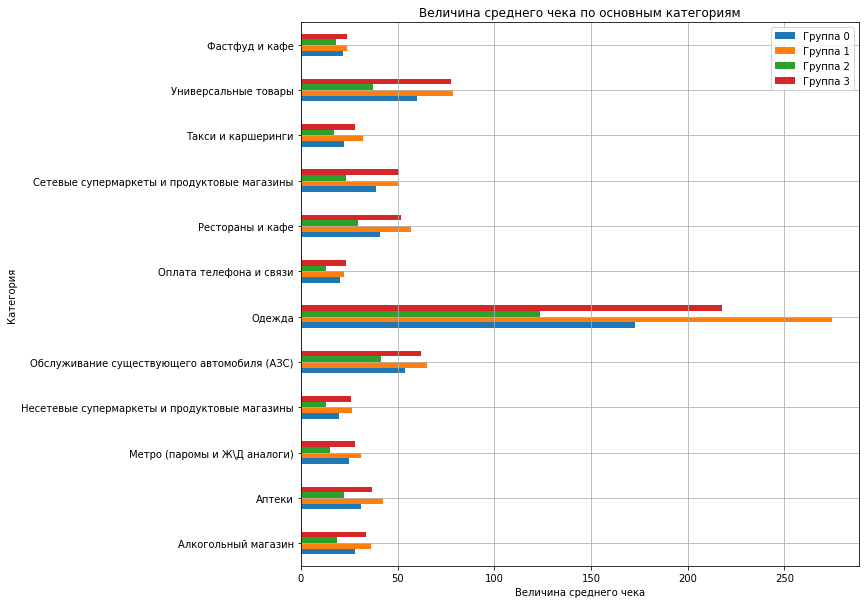

In [ ]:
common_popular_cat = set(categories_by_age[0].index[:10])
for i in range(1,4):
  common_popular_cat.update(categories_by_age[i].index[:10])
data_popular_cat = data.drop(data[~data.small_group.isin(common_popular_cat)].index)
data_popular_cat = data_popular_cat[['small_group','amount_rur','bins']].groupby(by = ['bins','small_group']).mean()
data_popular_cat_list = []
for bin,group in data_popular_cat.index:
  data_popular_cat_list.append([bin,group])
data_popular_cat = pd.DataFrame({'bin': np.array(data_popular_cat_list)[:,0],
                                  'group': np.array(data_popular_cat_list)[:,1],
                                  'value': (data_popular_cat.values.transpose()[0]).tolist()})
data_popular_cat_group = pd.DataFrame({'group': data_popular_cat.group.unique(),
                          'value_0': data_popular_cat[data_popular_cat.bin == '0']['value'].tolist(),
                          'value_1': data_popular_cat[data_popular_cat.bin == '1']['value'].tolist(),
                          'value_2': data_popular_cat[data_popular_cat.bin == '2']['value'].tolist(),
                          'value_3': data_popular_cat[data_popular_cat.bin == '3']['value'].tolist(),
                          })
data_popular_cat_group.set_index('group', inplace=True)
ax = data_popular_cat_group.plot.barh(figsize = (10,10))
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('Величина среднего чека')
ax.set_ylabel('Категория')
ax.set_title(f'Величина среднего чека по основным категориям')
ax.grid()


По полученной диаграмме видим, что по популярным категориям  по среднему чеку можно достаточно уверенно выделить группы 0 и 2. Однако разница между значениями для групп 1 и 3 не всегда значительна. По гистограмме видно, что наилучшее разделение достигается по категориям "Одежда", "Рестораны и кафе", "Аптеки".

Теперь проанализируем зависимость среднего чека по дням. Для этого построим для каждой группы график зависимости среднего чека от порядкового номера дня.

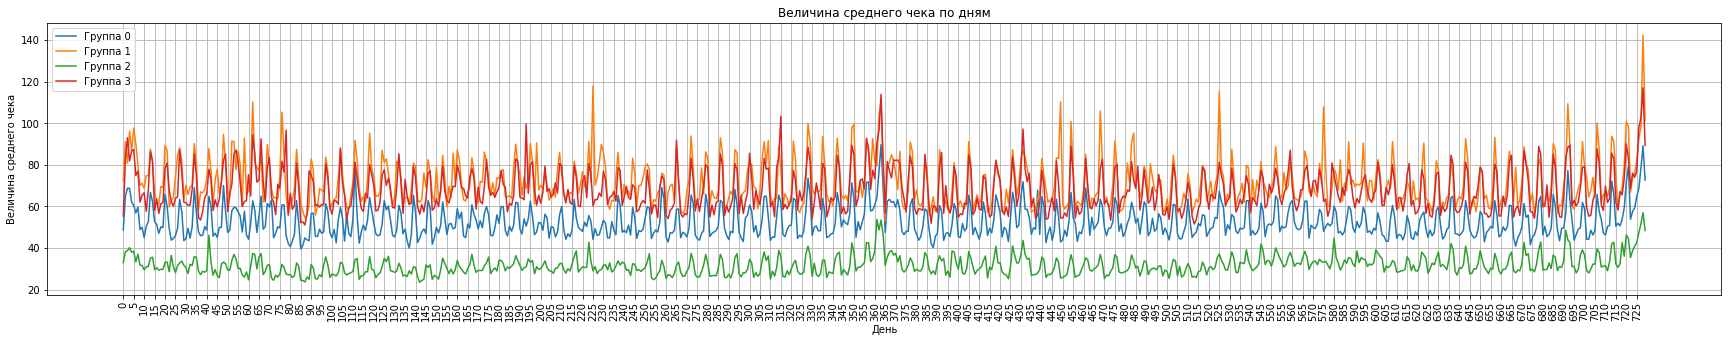

In [ ]:
mean_amount_per_day = data[['trans_date','amount_rur','bins']].groupby(['bins','trans_date']).mean()
mean_amount_per_day_list  = []
for bin,date in mean_amount_per_day.index:
  mean_amount_per_day_list.append([bin,date])
mean_amount_per_day = pd.DataFrame({'bin': np.array(mean_amount_per_day_list)[:,0],
                                  'date': np.array(mean_amount_per_day_list)[:,1],
                                  'value': (mean_amount_per_day.values.transpose()[0]).tolist()})
fig,ax = plt.subplots()
ax.plot(mean_amount_per_day[mean_amount_per_day.bin == 0]['date'], mean_amount_per_day[mean_amount_per_day.bin == 0]['value'])
ax.plot(mean_amount_per_day[mean_amount_per_day.bin == 1]['date'], mean_amount_per_day[mean_amount_per_day.bin == 1]['value'])
ax.plot(mean_amount_per_day[mean_amount_per_day.bin == 2]['date'], mean_amount_per_day[mean_amount_per_day.bin == 2]['value'])
ax.plot(mean_amount_per_day[mean_amount_per_day.bin == 3]['date'], mean_amount_per_day[mean_amount_per_day.bin == 3]['value'])
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('День')
ax.set_ylabel('Величина среднего чека')
ax.set_title(f'Величина среднего чека по дням')
plt.xticks(rotation=90)
ax.set_xticks(range(0,728,5))
ax.grid()
fig.set_size_inches(30,5)
plt.show()

Как и ожидалось, по среднему чеку можно с достаточной точностью отделить группы 0 и 2 и практически трудно отделить группы 1 и 3. По полученному графику видно пики для всех категорий в точках, близких к концу года (приблизительно 360 и 720 дни) и просадку в начале года (новогодние праздники). Также есть сложно объяснимые пики для группы 1 на 225 день и на 525 день. Проверим операции 1й группы за 225 день.

In [ ]:
data[data.trans_date == 225][data.bins == 1]['amount_rur'].sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


21216425    319685.683
22594853     35475.724
16322518     12921.028
22584987     12707.546
20853386     10329.060
               ...    
1910506          0.045
208820           0.045
24184875         0.043
1973031          0.043
25335370         0.002
Name: amount_rur, Length: 8124, dtype: float64

Видим, что данный всплеск происходит из-за единичной покупки на порядок выше среднего чека. Аналогично справедливо для других единичных всплесков.

Более подробно рассмотрим интервал в первых 2 месяца.

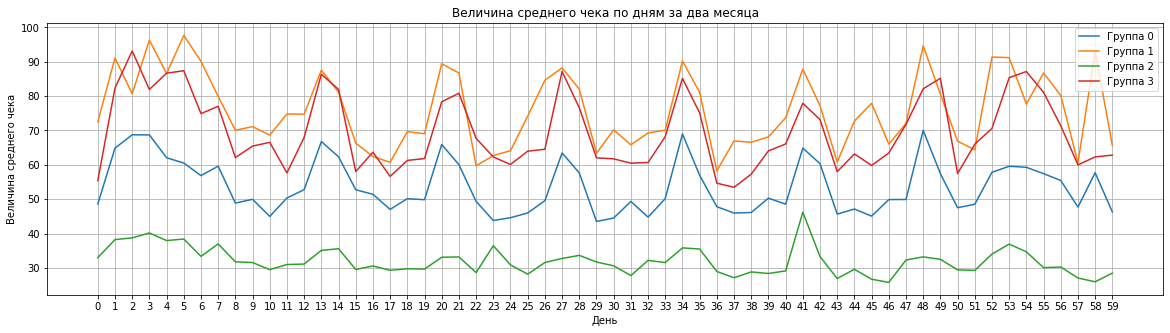

In [ ]:
mean_amount_period =  mean_amount_per_day[mean_amount_per_day.date <60]
fig,ax = plt.subplots()
ax.plot(mean_amount_period[mean_amount_period.bin == 0]['date'], mean_amount_period[mean_amount_period.bin == 0]['value'])
ax.plot(mean_amount_period[mean_amount_period.bin == 1]['date'], mean_amount_period[mean_amount_period.bin == 1]['value'])
ax.plot(mean_amount_period[mean_amount_period.bin == 2]['date'], mean_amount_period[mean_amount_period.bin == 2]['value'])
ax.plot(mean_amount_period[mean_amount_period.bin == 3]['date'], mean_amount_period[mean_amount_period.bin == 3]['value'])
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('День')
ax.set_xticks(range(60))
ax.set_ylabel('Величина среднего чека')
ax.set_title(f'Величина среднего чека по дням за два месяца')
ax.grid()
fig.set_size_inches(20,5)
plt.show()

По графику видно, что приблизительно каждый 7й день (13, 20, 27, 34 и.т.д) происходит увеличение значения среднего чека. Предположительно, это выходной день (суббота или воскресенье) в который происходят наиболее дорогие покупки по самой популярной категории (супермаркеты).

Теперь рассмотрим количество транзакция по группам в зависимости от дня.

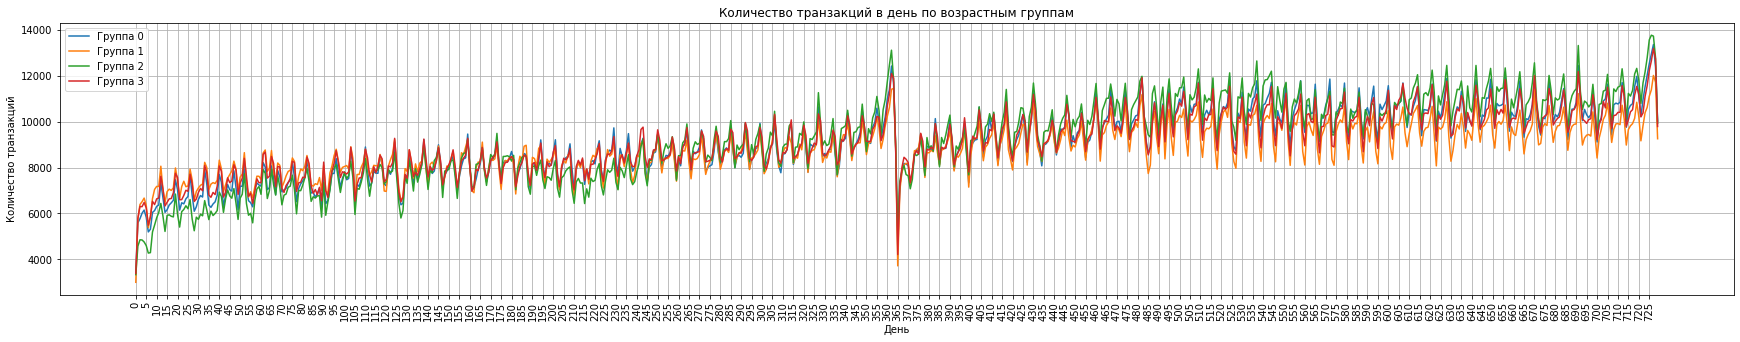

In [ ]:
mean_qty_per_day = data[['trans_date','bins']].groupby('trans_date')['bins'].value_counts()
mean_qty_per_day_list  = []
for date, bin in mean_qty_per_day.index:
  mean_qty_per_day_list.append([date, bin])
mean_qty_per_day = pd.DataFrame({'date': np.array(mean_qty_per_day_list)[:,0],
                                  'bin': np.array(mean_qty_per_day_list)[:,1],
                                  'value': mean_qty_per_day.values.tolist()})
fig,ax = plt.subplots()
ax.plot(mean_qty_per_day[mean_qty_per_day.bin == 0]['date'], mean_qty_per_day[mean_qty_per_day.bin == 0]['value'])
ax.plot(mean_qty_per_day[mean_qty_per_day.bin == 1]['date'], mean_qty_per_day[mean_qty_per_day.bin == 1]['value'])
ax.plot(mean_qty_per_day[mean_qty_per_day.bin == 2]['date'], mean_qty_per_day[mean_qty_per_day.bin == 2]['value'])
ax.plot(mean_qty_per_day[mean_qty_per_day.bin == 3]['date'], mean_qty_per_day[mean_qty_per_day.bin == 3]['value'])
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('День')
plt.xticks(rotation=90)
ax.set_xticks(range(0,728,5))
ax.set_ylabel('Количество транзакций')
ax.set_title(f'Количество транзакций в день по возрастным группам')
ax.grid()
fig.set_size_inches(30,5)
plt.show()

На полученном графике видно, что аналогично зависимости среднего чека от даты в данной зависимости также присутствуют пики в окресности конца года и провалы в начале года. Рассмотрим период в первые 3 месяца подробнее.

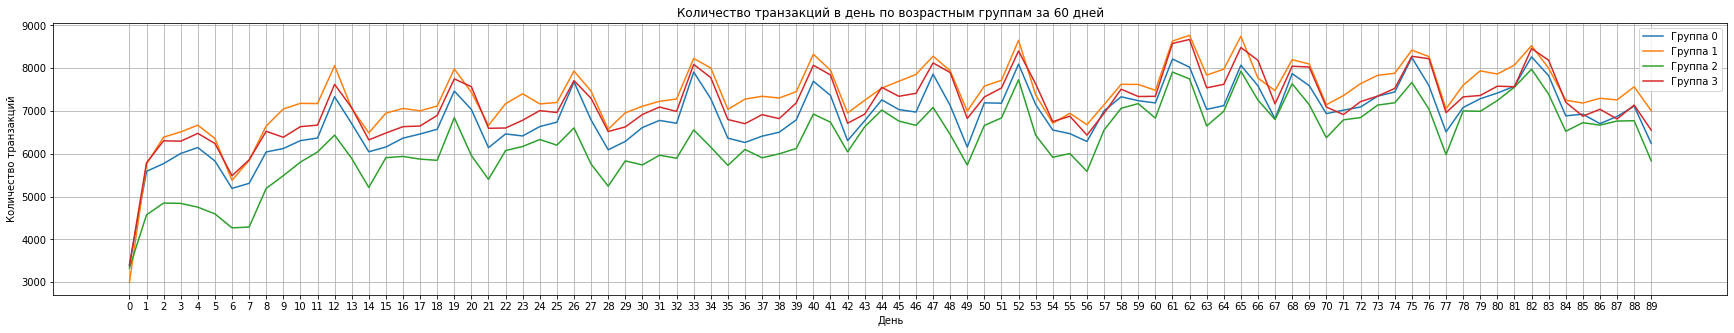

In [ ]:
mean_qty_period = mean_qty_per_day[mean_qty_per_day.date < 90]
fig,ax = plt.subplots()
ax.plot(mean_qty_period[mean_qty_period.bin == 0]['date'], mean_qty_period[mean_qty_period.bin == 0]['value'])
ax.plot(mean_qty_period[mean_qty_period.bin == 1]['date'], mean_qty_period[mean_qty_period.bin == 1]['value'])
ax.plot(mean_qty_period[mean_qty_period.bin == 2]['date'], mean_qty_period[mean_qty_period.bin == 2]['value'])
ax.plot(mean_qty_period[mean_qty_period.bin == 3]['date'], mean_qty_period[mean_qty_period.bin == 3]['value'])
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('День')
ax.set_xticks(range(90))
ax.set_ylabel('Количество транзакций')
ax.set_title(f'Количество транзакций в день по возрастным группам за 60 дней')
ax.grid()
fig.set_size_inches(30,5)
plt.show()

На полученном графике видно, что 2я группа может быть достаточно уверенно отделена по количеству транзакций в день. Наиболее трудная задача состоит в отделении группы 1 от группы 3. Однако можно заметить, что каждые 7 дней в течении 4х дней количество транзакций для группы 1 стабильно больше, чем количество транзакций для группы 3 (дни 8-12, 14-18, 21-25, 28-32, 35-39, 42-46 и.т.д). Предположительно, это траты на буднях. Рассмотрим, что происходит в эти дни (на примере дней 21-25 и 42-46) на графиках.

In [ ]:
def scatter_for_n_popular_cats(day_start,day_finish, qty_cat = 20):
  common_popular_cat = set(categories_by_age[0].index[:qty_cat])
  for i in range(1,4):
    common_popular_cat.intersection_update(categories_by_age[i].index[:qty_cat])
  mask = (data.trans_date >= day_start) & (data.trans_date <= day_finish) & (data.small_group.isin(common_popular_cat))
  data_days = data[mask]

  data_days_stat = data_days.groupby(['bins','small_group'])['client_id'].count()
  data_days_stat_list  = []
  for bin, group in data_days_stat.index:
    data_days_stat_list.append([bin, group])
  data_days_stat = pd.DataFrame({'bin': np.array(data_days_stat_list)[:,0],
                                  'group': np.array(data_days_stat_list)[:,1],
                                  'value': data_days_stat.values.tolist()})

  
  fig,ax = plt.subplots()
  sns.scatterplot(data = data_days_stat, y = "group", x= "bin", size="value", hue = "value",sizes = (30,500))
  ax.set_xlabel('Возрасная группа')
  ax.set_ylabel('Группы')
  ax.set_title(f'Количество транзакций в дни {day_start}-{day_finish} по основным категориям')
  fig.set_size_inches(8,3)
  plt.show()

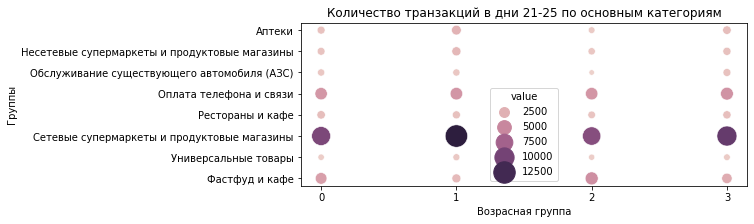

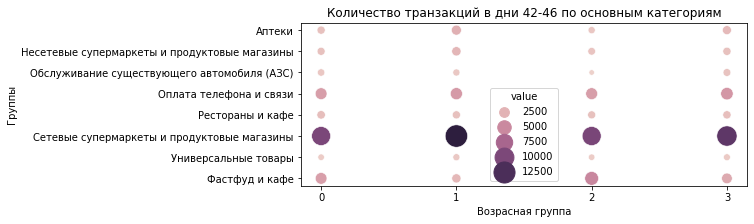

In [ ]:
scatter_for_n_popular_cats(21,25,10)
scatter_for_n_popular_cats(42,46,10)

По полученным диаграммам видно, что группы 1 и 3 можно различить по количеству транзакций категории "Сетевые супермаркеты и продуктовые магазины" по будним дням (группа 1 делает больше транзакций). При этом отметим, что группа 3 в эти же дни делает больше чем группа 1 транзакций по категории "Фастфуд и кафе"  (при этом меньше, чем группа 2). Также можно заметить в среднем большее значение транзакций в категории аптеки для группы 1.

Попробуем дифференцировать клиентов по среднемесячным расходом (предпологая корреляцию со среднемесячными доходами). Для этого посчитаем среднимесячные расходы за первый год для каждого клиента и усредним по группе. Построим по полученным данным гистограмму.

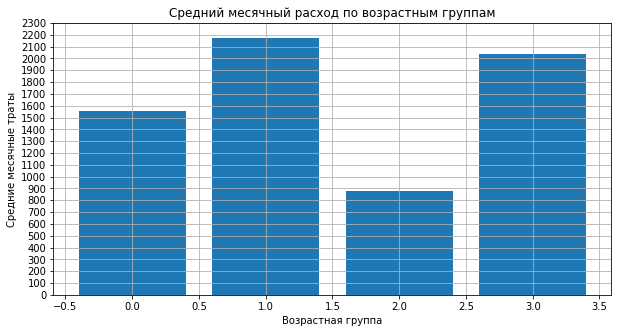

In [ ]:
months = [(0,31),(31,59),(59,90),(90,120),(120,151),(151,181),(181,212),(212,243),(243,273),(273,304),(304,334),(334,365)]
clients_sum = data[['client_id','amount_rur']][data.trans_date.isin(range(*months[0]))].groupby('client_id')['amount_rur'].sum().to_frame()
for i in range(1,len(months)):
   clients_sum = pd.merge(data[['client_id','amount_rur']][data.trans_date.isin(range(*months[i]))].groupby('client_id')['amount_rur'].sum().to_frame(),clients_sum,on="client_id")
clients_sum['aver_amount'] = clients_sum.iloc[:, 1:13].sum(axis=1)/12
clients_sum = pd.merge(clients_sum, target, on="client_id")
clients_sum.drop(clients_sum.columns[range(1,13)], axis=1, inplace=True)
month_out = clients_sum.groupby('bins')['aver_amount'].mean()
fig,ax = plt.subplots()
ax.bar(month_out.index, month_out.values)
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Средние месячные траты')
ax.set_title(f'Средний месячный расход по возрастным группам')
ax.set_yticks(range(0,2400,100))
ax.grid()
fig.set_size_inches(10,5)
plt.show()

Видно, что среднемесячные расход достаточно уверенно разделяет группы. При этом ожидаемо значения для 1 и 3 группы довольно близки.

Постараемся найти категории, которые наиболее характерны для той или иной группы. Для начала воспользуемся метрикой количества транзакций. Посчитаем для каждой группы количество транзакций по категориям, объединим эти значения в общий датафрейм (по столбцу small_group). Затем для каждой категории усредним количество транзакций по группам и найдем нормированное стандартное отклонение (количество транзакций по категориям также нормируем для удобства построения общего графика). Полученный датафрейм отсортируем сначала по среднему значению (чтобы исключить влияние редких категорий с малым количеством данных), а затем по отклонению. Отберем первые 10 категорий со стандартным отклонением большим 0,2. По полученным категориям построим гистограмму нормированного среднего по категориям.

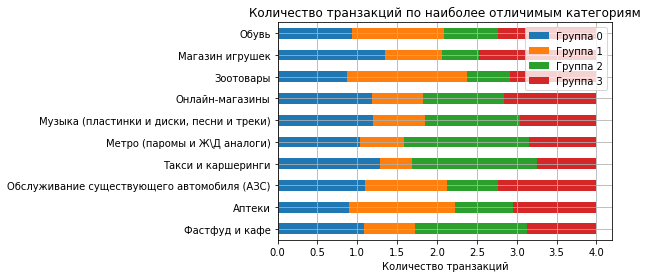

In [ ]:
qty_trans_by_group_0 = data[data.bins == 0]['small_group'].value_counts().to_frame()
qty_trans_by_group_1 = data[data.bins == 1]['small_group'].value_counts().to_frame()
qty_trans_by_group_2 = data[data.bins == 2]['small_group'].value_counts().to_frame()
qty_trans_by_group_3 = data[data.bins == 3]['small_group'].value_counts().to_frame()
qty_trans_by_group = qty_trans_by_group_0.join(qty_trans_by_group_1, lsuffix = '_0',rsuffix = '_1', how = 'inner')
qty_trans_by_group = qty_trans_by_group.join(qty_trans_by_group_2, rsuffix = '_2', how = 'inner')
qty_trans_by_group = qty_trans_by_group.join(qty_trans_by_group_3, rsuffix = '_3', how = 'inner')
qty_trans_by_group['mean'] = qty_trans_by_group.mean(axis=1)
qty_trans_by_group['std_n'] = qty_trans_by_group.std(axis=1)/qty_trans_by_group['mean']
qty_trans_by_group.iloc[:,0:4] = qty_trans_by_group.iloc[:,0:4].div(qty_trans_by_group['mean'], axis = 0)
qty_trans_by_group.sort_values(by = ['mean','std_n'],inplace=True, ascending=False)
pd.set_option( "display.max_columns", None)
diff_cats = qty_trans_by_group[qty_trans_by_group['std_n'] > 0.2].iloc[:10,:]
ax = diff_cats.iloc[:,:4].plot.barh(stacked=True)
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('Количество транзакций')
ax.set_title(f'Количество транзакций по наиболее отличимым категориям')
ax.grid()

По полученной гистограмме видно, что группы действительно достаточно хорошо разделяются по выбранным категориям. 

Аналогично поступим для метрики средний чек по категории. Удалим категории с количеством транзакций меньше 1000 во избежание влияния малочисленных нерепрезентативных транзакций. Аналогично предыдущему пункту посчитаем средний чек для каждой возрастной группы для каждой категории, объединим их в общий датафрейм, посчитаем нормированное среднее отклонение по категории и возьмем категории с отклонением больше 0,2.  Построим гистограмму.

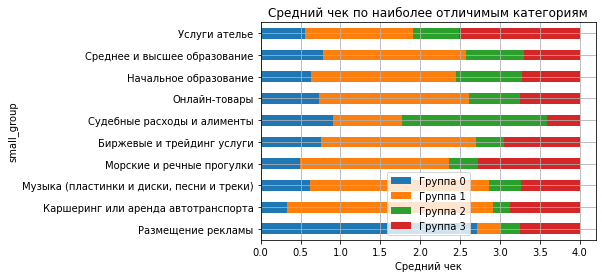

In [ ]:
rare_categories = categories[categories<=1000]
data_ = data.drop(data[data.small_group.isin(rare_categories.index.to_list())].index)
mean_trans_by_group_0 = data_[data_.bins == 0][['amount_rur','small_group']].groupby('small_group').mean()
mean_trans_by_group_1 = data_[data_.bins == 1][['amount_rur','small_group']].groupby('small_group').mean()
mean_trans_by_group_2 = data_[data_.bins == 2][['amount_rur','small_group']].groupby('small_group').mean()
mean_trans_by_group_3 = data_[data_.bins == 3][['amount_rur','small_group']].groupby('small_group').mean()
mean_trans_by_group = mean_trans_by_group_0.join(mean_trans_by_group_1, lsuffix = '_0',rsuffix = '_1', how = 'inner')
mean_trans_by_group = mean_trans_by_group.join(mean_trans_by_group_2, rsuffix = '_2', how = 'inner')
mean_trans_by_group = mean_trans_by_group.join(mean_trans_by_group_3, rsuffix = '_3', how = 'inner')
mean_trans_by_group['mean'] = mean_trans_by_group.mean(axis=1)
mean_trans_by_group['std_n'] = mean_trans_by_group.std(axis=1)/mean_trans_by_group['mean']
mean_trans_by_group.iloc[:,0:4] = mean_trans_by_group.iloc[:,0:4].div(mean_trans_by_group['mean'], axis = 0)
mean_trans_by_group.sort_values(by = 'std_n',inplace=True, ascending=False)
pd.set_option( "display.max_columns", None)
diff_cats_mean =mean_trans_by_group[mean_trans_by_group['std_n'] > 0.2].iloc[:10,:]
ax = diff_cats_mean.iloc[:,:4].plot.barh(stacked=True)
ax.legend(['Группа 0','Группа 1','Группа 2','Группа 3'])
ax.set_xlabel('Средний чек')
ax.set_title(f'Средний чек по наиболее отличимым категориям')
ax.grid()

Заметим, что при обоих делениях присутствует категория "Музыка.

##Выводы:##
В ходе анализа предоставленных данных был выдвинут  ряд предположений о разделимости данных по различным метрикам. Продолжением данного анализа является формирование признаков с учетом выдвинутых предположений и обучение моделей машиного обучения для предсказаний требуемой величины и проверки гипотез.
